In [41]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 6]
import matplotlib.dates as dates
import seaborn as sns
import arviz as az

In [42]:
from datetime import datetime
custom_date_parser = lambda x: datetime.strptime(x, "%d.%m.%Y")

In [43]:
data = pd.read_csv("data.tsv",sep=",",parse_dates=["Datum"],date_parser=custom_date_parser)
data

,Datum,Gewicht
0,2022-03-01,92.9
1,2022-03-12,92.4
2,2022-03-17,92.2
3,2022-03-20,91.7
4,2022-03-24,92.0
5,2022-03-25,91.3
6,2022-03-29,91.0
7,2022-03-30,90.7
8,2022-04-03,90.8
9,2022-04-05,90.4


In [44]:
target = data["Gewicht"][0] - 10.0

In [45]:
from scipy import stats

In [46]:
from datetime import timedelta

In [47]:
def ts2num(ts):
    ref = data['Datum'][0]
    return float((ts-ref).days)

In [48]:
def num2ts(tsNum):
    ref = data['Datum'][0]
    return ref + timedelta(days = tsNum)

In [49]:
data['Datum_num']=data['Datum'].map(ts2num)

In [50]:
n = len(data)

C:\devsbb\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


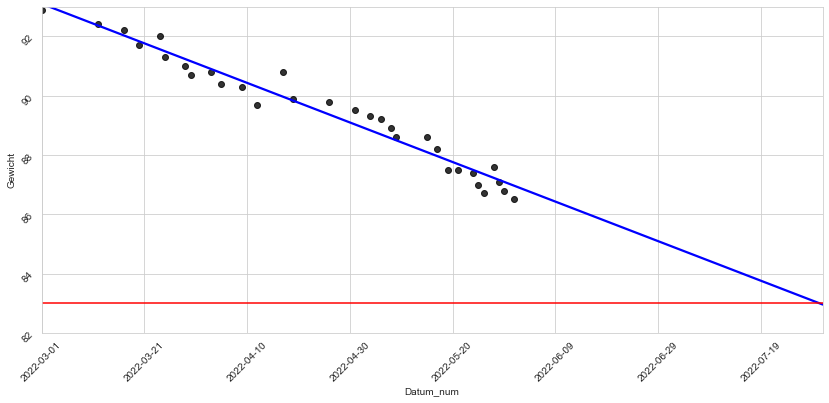

In [51]:
@plt.FuncFormatter
def fake_dates(x, pos):
    return num2ts(x).strftime('%Y-%m-%d')

fig, ax = plt.subplots()
ax.set_xlim([data.Datum_num[0],data.Datum_num[n-1]+60])
ax.set_ylim([82,93])
# just use regplot if you don't need a FacetGrid
sns.regplot('Datum_num', 'Gewicht', data=data, ax=ax,ci=0, color="black",line_kws={"color": "blue"},truncate=False)
plt.axhline(83, color = 'r', linestyle = '-')

# here's the magic:
ax.xaxis.set_major_formatter(fake_dates)

# legible labels
ax.tick_params(labelrotation=45)

### normale Lineare Regression

In [52]:
from scipy import stats
slopeLR, interceptLR, r_value, pv, se = stats.linregress(data["Datum_num"],data["Gewicht"])

In [53]:
interceptLR

93.10011021764103

In [54]:
slopeLR

-0.06674687199230032

In [55]:
num2ts((target - interceptLR)/slopeLR)

Timestamp('2022-07-31 19:37:38.027304')

### Lineare Regression mit Konfidenzinterval

In [109]:
arr= np.linspace(start=0,stop=230, num=1000)
dataPred = pd.DataFrame(data=arr,columns=['Datum_num'])

In [110]:
import statsmodels.formula.api as smf
model = smf.ols(formula='Gewicht ~ Datum_num', data=data)

results = model.fit()

alpha = .05

predictions = results.get_prediction(dataPred).summary_frame(alpha)

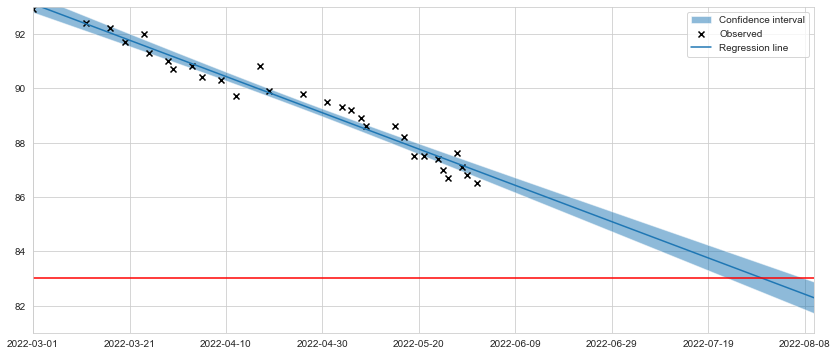

In [111]:
fig, ax = plt.subplots()
ax.set_xlim([data.Datum_num[0],data.Datum_num[n-1]+70])
ax.set_ylim([81,93])
plt.fill_between(dataPred['Datum_num'], predictions['mean_ci_lower'], predictions['mean_ci_upper'], alpha=.5, label='Confidence interval')
plt.scatter(data['Datum_num'], data['Gewicht'], label='Observed', marker='x', color='black')
plt.plot(dataPred['Datum_num'], predictions['mean'], label='Regression line')
plt.legend()
ax.xaxis.set_major_formatter(fake_dates)
plt.axhline(83, color = 'r', linestyle = '-')
plt.show()

In [112]:
### Schnittpunkte Konfidenz-Intervall

In [113]:
num2ts(dataPred['Datum_num'][np.array(np.abs(predictions['mean_ci_lower']-target)).argmin()])

Timestamp('2022-07-24 12:07:55.675676')

In [114]:
num2ts(dataPred['Datum_num'][np.array(np.abs(predictions['mean_ci_upper']-target)).argmin()])

Timestamp('2022-08-09 09:23:36.216216')

# MCMC

In [108]:
x = data["Datum_num"]
y = data["Gewicht"]

In [17]:
model = pm.Model()
niter = 2000
with model:
    slope = pm.Normal('slope', mu=0.0, sigma=5)
    intercept = pm.Normal('intercept', mu=y[0], sigma=5)
    sigma = pm.HalfNormal('sigma',sigma=10)

    y_est = slope*x + intercept
    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y)
    trace = pm.sample(draws=niter,tune=2000)

C:\Users\U230261\AppData\Local\Temp\ipykernel_5360\919441470.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=niter,tune=2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 60 seconds.


Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


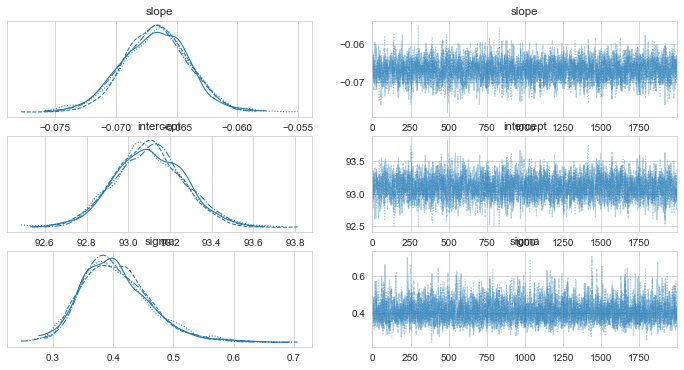

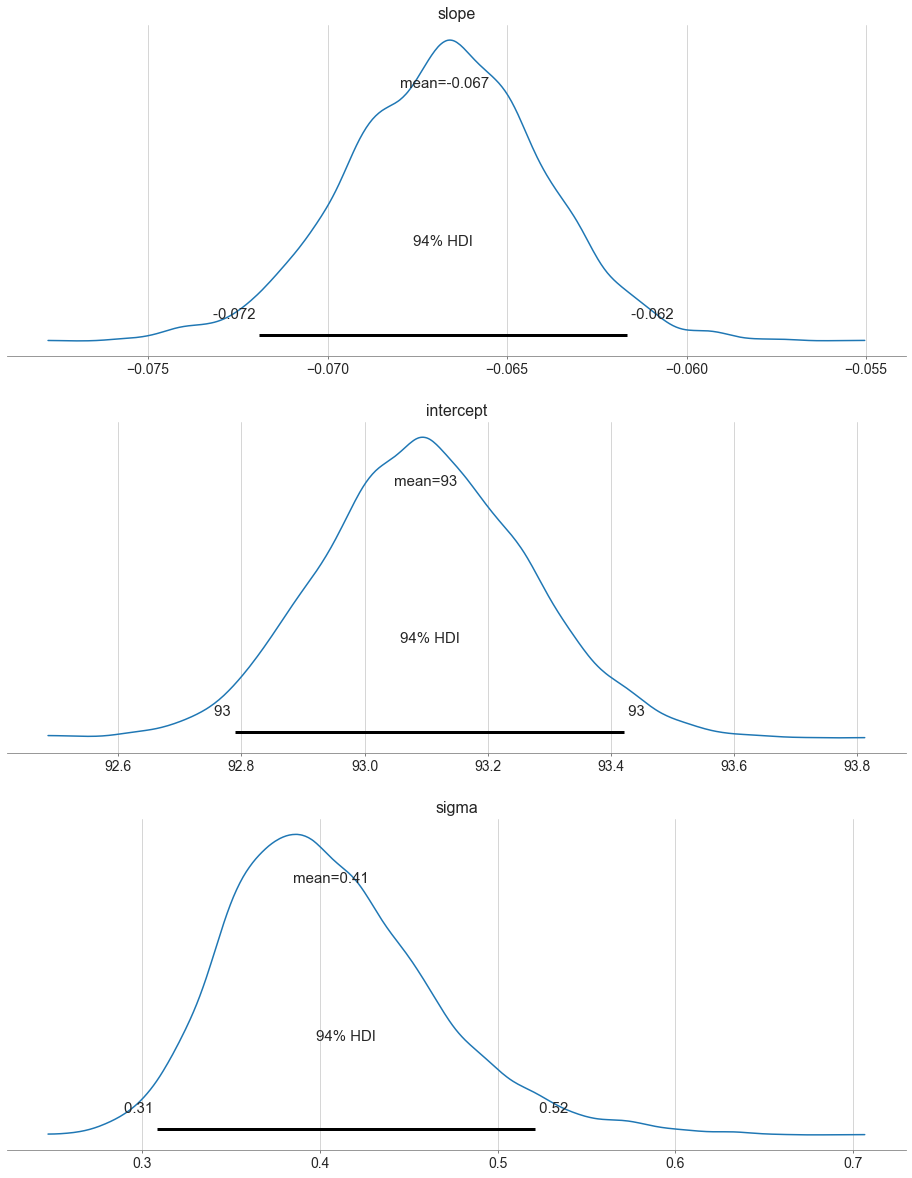

In [18]:
with model:
    pm.plots.plot_trace(trace)
    pm.plots.plot_posterior(trace,grid=(3,1))

In [33]:
xext = np.linspace(start=x[0],stop=175)

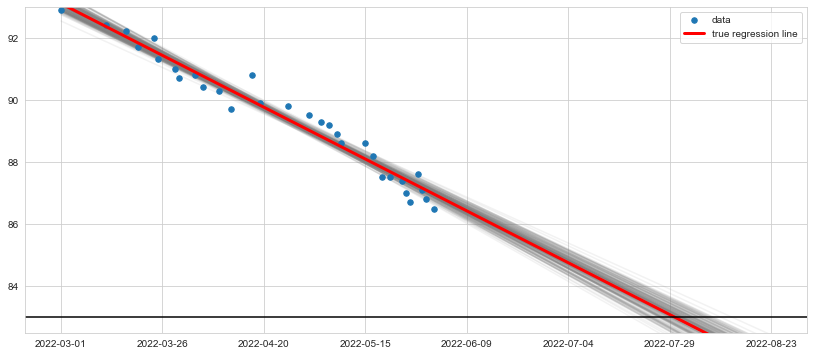

In [40]:
fig, ax = plt.subplots()
plt.scatter(x, y, s=30, label='data',zorder=2)
for a_, b_ in zip(trace['slope'][-200:], trace['intercept'][-200:]):
    plt.plot(xext, a_*xext + b_, c='gray', alpha=0.1,zorder=1)
plt.plot(xext, slopeLR*xext + interceptLR, label='true regression line', lw=3., c='red')
plt.axhline(83, color = 'black', linestyle = '-')
ax.xaxis.set_major_formatter(fake_dates)
ax.set_ylim(82.5,93)
plt.legend(loc='best')

## Berechnung Schnittpunkt mit Zielgewicht

In [20]:
targetTime = np.zeros(trace['slope'].size)

In [21]:
for (i,(a,b)) in enumerate(zip(trace['slope'], trace['intercept'])):
    targetTime[i] = (target - b)/a

In [22]:
xstart,median,xend = np.percentile(targetTime, [2.5,50,97.5])
xstart,median,xend

(145.0784910101716, 152.8700393304241, 161.52118106795203)

In [23]:
num2ts(xstart),num2ts(median),num2ts(xend)

(Timestamp('2022-07-24 01:53:01.623279'),
 Timestamp('2022-07-31 20:52:51.398149'),
 Timestamp('2022-08-09 12:30:30.044271'))

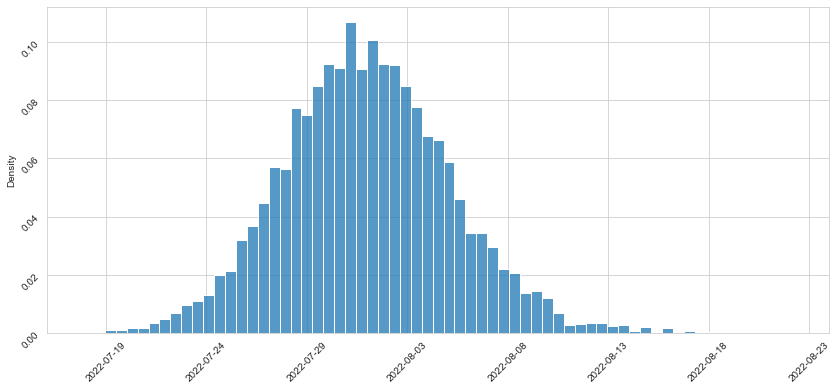

In [24]:
@plt.FuncFormatter
def fake_dates(x, pos):
    return num2ts(x).strftime('%Y-%m-%d')

fig, ax = plt.subplots()
sns.histplot(targetTime, kde=False,stat = "density", ax = ax)

# here's the magic:
ax.xaxis.set_major_formatter(fake_dates)

# legible labels
ax.tick_params(labelrotation=45)

# Bootstrapping